# Requirements

In [1]:
import re
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString
import seaborn as sns
import sddk

In [18]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

# Import datasets

In [3]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
RE = pleiades_regions.unary_union
pleiades_regions_merged = gpd.GeoSeries(RE)

In [4]:
GIST = gpd.read_parquet("../data/large_data/GIST_v0-1.parquet")

In [43]:
GIST["date_type"].tolist()[0]["data"]

['range', 'phase', 'ca']

In [44]:
for col in GIST.columns:
    if isinstance(GIST[col].tolist()[0], dict):
        GIST[col] = GIST[col].apply(lambda x: {"data" : list(x["data"])})

In [45]:
len(GIST)

217863

In [46]:
# geocoded
len(GIST[GIST["x_long"].notnull()])

180061

In [47]:
# with temporal info
len(GIST[(GIST["not_after"].notnull()) | (GIST["not_before"].notnull())])

131677

In [48]:
(GIST["not_after"]>=-50).sum()

72957

In [49]:
# from Roman imperial times
sum((GIST["not_after"]>=-50) & (GIST["not_before"] <=350))

66419

In [50]:
# geocoded & from roman times
sum((GIST["not_after"]>=-50) & (GIST["not_before"] <=350) & (GIST["x_long"].notnull()))

54404

In [51]:
GIRE = GIST[(GIST["not_after"]>=-50) & (GIST["not_before"] <=350) & (GIST["x_long"].notnull())].copy()
len(GIRE)

54404

In [52]:
%%time
GIRE = GIRE[GIRE.within(RE)].copy()
len(GIRE)

CPU times: user 2min 22s, sys: 1.62 s, total: 2min 23s
Wall time: 2min 24s


44313

(22.0, 55.5)

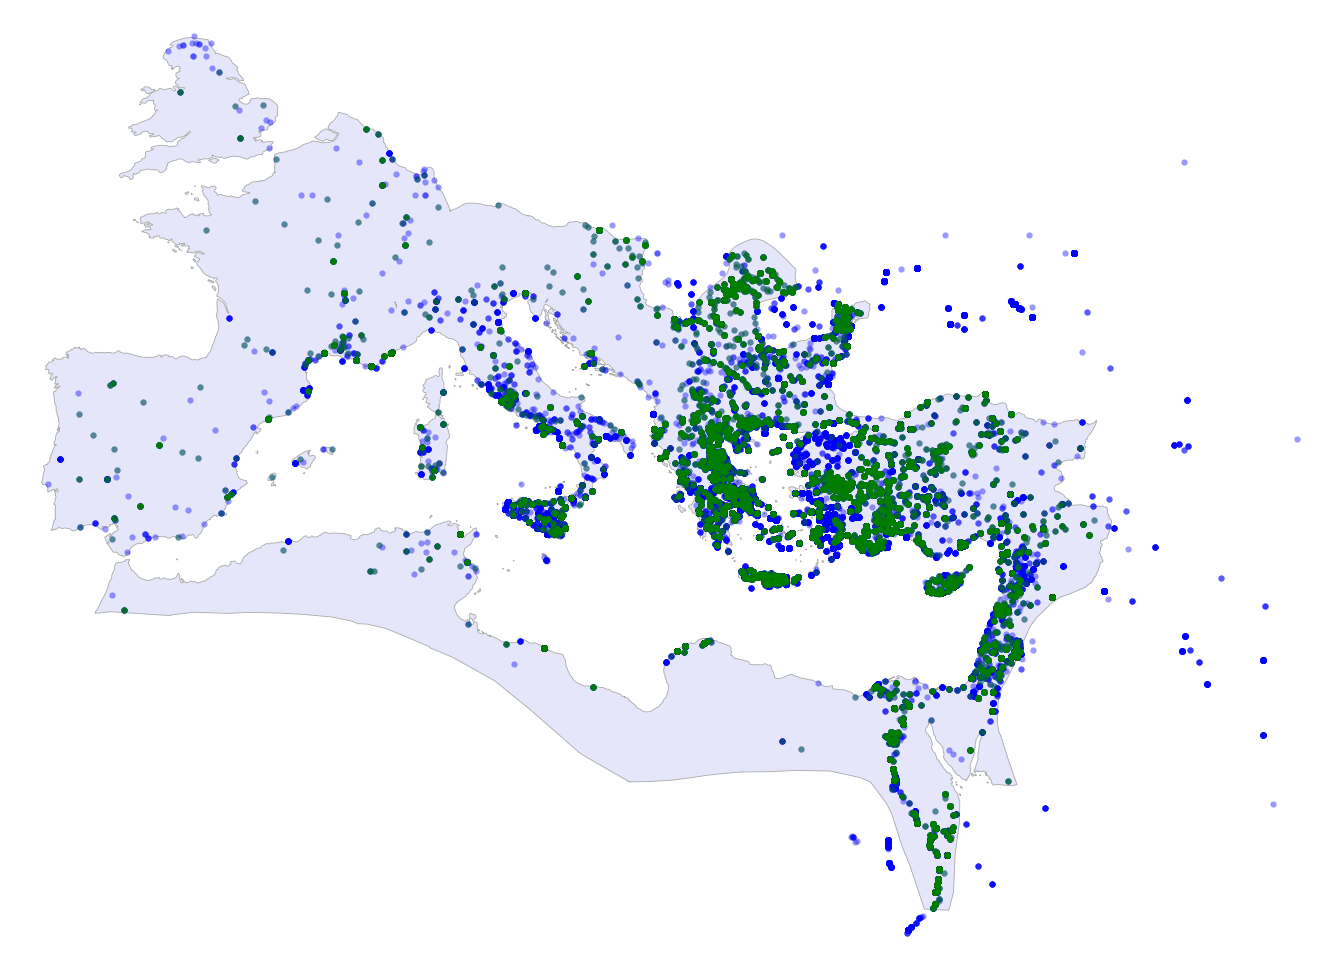

In [53]:
fig, ax = plt.subplots()
pleiades_regions_merged.plot(ax=ax, edgecolor="darkgrey" , linewidth=0.2, color="lavender")
#gplt.kdeplot(PHI[PHI["x_long"].notnull()], cmap=plt.get_cmap("Greens"), ax=ax, alpha=0.5, shade=True, zorder=2)
GIST.plot(ax=ax, marker=".", markersize=1, color="blue", zorder=3, alpha=0.4)
GIRE.plot(ax=ax, marker=".", markersize=1, color="green", zorder=3, alpha=0.4)
ax.set_axis_off()
ax.set_xlim(-10, 50)
ax.set_ylim(22, 55.5)
#ax.set_title(title + " (N={0})".format(str(len(subset))))

In [54]:
GIRE["GIRE_ID"] = range(1, len(GIRE)+1)

In [55]:
GIRE.set_index("GIRE_ID", inplace=True)

In [56]:
cols = ["geometry"]
cols_problematic = []
for col in GIRE.columns:
    try:
        GIRE[["geometry"] + [col]].to_file("../data/giretest.geojson")
    except:
        cols_problematic.append(col)

In [60]:
GIRE.to_file("../data/large_data/GIRE_v0.1.geojson", driver="GeoJSON")

In [61]:
GIRE.to_parquet("../data/large_data/GIRE_v0.1.parquet")